In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


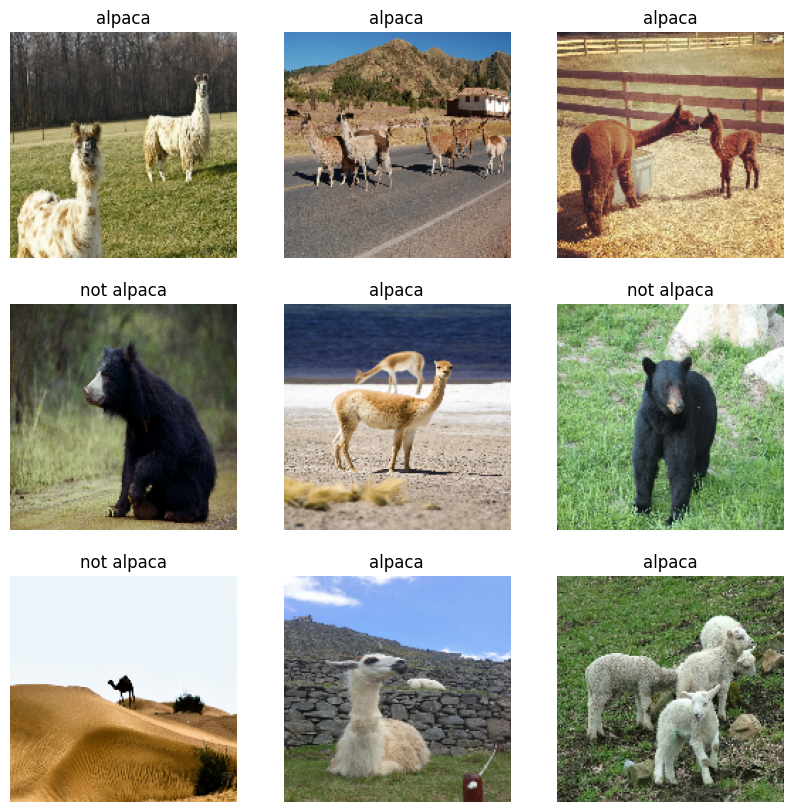

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))

    return data_augmentation

In [6]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
data_augmentation = data_augmenter()

In [12]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_path="imagenet_base_model/with_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160.h5"

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights=base_model_path)

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [14]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model_path="imagenet_base_model/without_top_mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_160_no_top.h5"
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, 
                                                   weights=base_model_path)
    base_model.trainable = False

    # input layer 
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # normalizing
    x = preprocess_input(x) 
    x = base_model(x, training=False) 
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(rate=0.2)(x) 

    # 'linear' in anticipation for 'from logits=True' 
    outputs = tfl.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [15]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [16]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\ashem\miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 11s 244ms/step - loss: 0.8954 - accuracy: 0.4389 - val_loss: 0.6298 - val_accuracy: 0.6000
Epoch 2/5
9/9 [==============================] - 1s 114ms/step - loss: 0.7245 - accuracy: 0.6221 - val_loss: 0.5084 - val_accuracy: 0.6462
Epoch 3/5
9/9 [==============================] - 1s 114ms/step - loss: 0.5925 - accuracy: 0.6641 - val_loss: 0.4389 - val_accuracy: 0.6462
Epoch 4/5
9/9 [==============================] - 1s 123ms/step - loss: 0.5152 - accuracy: 0.6794 - val_loss: 0.3730 - val_accuracy: 0.7385
Epoch 5/5
9/9 [==============================] - 1s 111ms/step - loss: 0.4269 - accuracy: 0.7939 - val_loss: 0.3077 - val_accuracy: 0.8462


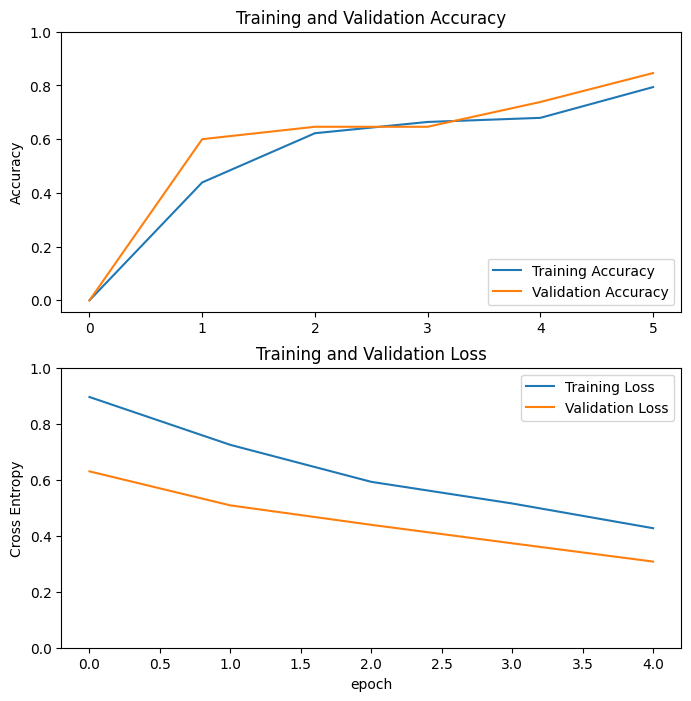

In [18]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
base_model = model2.layers[4]
base_model.trainable = True

fine_tune_at = 120

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = optimizer=tf.keras.optimizers.Adam(lr=0.1 * base_learning_rate)
metrics=['accuracy']

In [20]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/15
9/9 [==============================] - 1s 115ms/step - loss: 0.4091 - accuracy: 0.7748 - val_loss: 0.3045 - val_accuracy: 0.7846
Epoch 6/15
9/9 [==============================] - 1s 116ms/step - loss: 0.3955 - accuracy: 0.7824 - val_loss: 0.2624 - val_accuracy: 0.8462
Epoch 7/15
9/9 [==============================] - 1s 117ms/step - loss: 0.3399 - accuracy: 0.8626 - val_loss: 0.2271 - val_accuracy: 0.8923
Epoch 8/15
9/9 [==============================] - 1s 116ms/step - loss: 0.3525 - accuracy: 0.8321 - val_loss: 0.2394 - val_accuracy: 0.8615
Epoch 9/15
9/9 [==============================] - 1s 118ms/step - loss: 0.3069 - accuracy: 0.8740 - val_loss: 0.2043 - val_accuracy: 0.8769
Epoch 10/15
9/9 [==============================] - 1s 117ms/step - loss: 0.3049 - accuracy: 0.8511 - val_loss: 0.2001 - val_accuracy: 0.8769
Epoch 11/15
9/9 [==============================] - 1s 111ms/step - loss: 0.2898 - accuracy: 0.8626 - val_loss: 0.1888 - val_accuracy: 0.8923
Epoch 12/15
9/9 [=

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

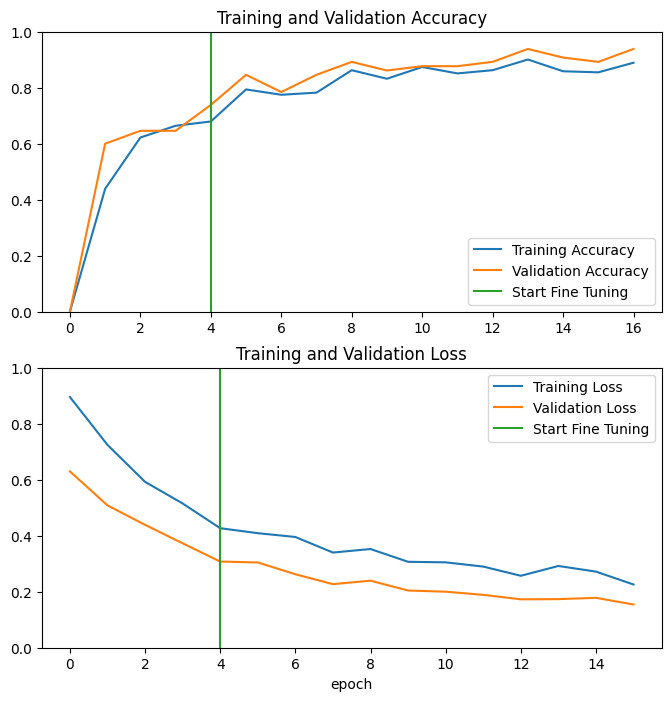

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()